In [34]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
from pysptools.distance import SAM, NormXCorr  
import pysptools.material_count as cnt

from earthpy.spatial import bytescale

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf1 = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf1.crs))



point CRS: {'init': 'epsg:32613'}


In [3]:
gdf = gdf1.drop(1).reset_index()
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

index  Id              comments  \
0      0   0      dirt parking lot   
1      2   0  tennis court (south)   
2      3   0               red hut   
3      4   0   grass patch (south)   
4      5   0         leaf off tree   

                                       geometry  
0  POINT (-105.2320413087213 39.97927552633687)  
1  POINT (-105.2321048858712 39.97956622917603)  
2   POINT (-105.2320315564236 39.9796903363637)  
3  POINT (-105.2319140238961 39.97865502556768)  
4  POINT (-105.2320006579609 39.97880026728588)

In [4]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
neon_radiance_file = data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_radiance.h5'

# headwall radiance files... these were built 'by hand' in ENVI
radiance_files_VNIR_april09 = glob('../headwall_data/raw/radiance/VNIR_CUSouth/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob('../headwall_data/raw/radiance/SWIR_CUSouth/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr

# construct the filename pairs with the block numbers
vs_pairs = [(0,0), (2000,2000), (4000,4000)]
hw_vs_pair_names = []
for p in vs_pairs:
    v_block, s_block = p
    v_file = [f for f in radiance_files_VNIR_april09 if f'block{v_block}' in f][0]
    s_file = [f for f in radiance_files_SWIR_april09 if f'block{s_block}' in f][0]
    hw_vs_pair_names.append((v_file, s_file))
    
hw_lbl = [f'HW-{v}-{s}' for v,s in vs_pairs]
hw_lbl

['HW-0-0', 'HW-2000-2000', 'HW-4000-4000']

In [5]:
hw_vs_pair_names

[('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block0_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block0_swir_rad_glt_cor'),
 ('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block2000_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block2000_swir_rad_glt_cor'),
 ('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block4000_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block4000_swir_rad_glt_cor')]

In [6]:
# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
reflectance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
reflectance_files_VNIR_april09 = [f[:-4] for f in reflectance_files_VNIR_april09] # remove the .hdr

reflectance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
reflectance_files_SWIR_april09 = [f[:-4] for f in reflectance_files_SWIR_april09] # remove the .hdr

In [7]:
data_file_NEON = neon_radiance_file

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)

NEON ID:  V10C


In [8]:
xarr_VNIR_ls, xarr_SWIR_ls, x_vnir_ls, y_vnir_ls, x_swir_ls, y_swir_ls = [], [], [], [], [], []

for data_file_VNIR, data_file_SWIR in hw_vs_pair_names:
    ## read the data into xarray datasets, chunk with Dask
    # first Headwall
    xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
    xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
    x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
    x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

    # in this case, need to extract out the wavelength information!
    band_vnir = xr.open_rasterio(reflectance_files_VNIR_april09[0]).coords['band']
    band_swir = xr.open_rasterio(reflectance_files_SWIR_april09[0]).coords['band']

    xarr_VNIR.coords['band'] = band_vnir
    xarr_SWIR.coords['band'] = band_swir
    
    # append to lists
    xarr_VNIR_ls.append(xarr_VNIR)
    x_vnir_ls.append(x_vnir)
    y_vnir_ls.append(y_vnir)
    
    # append to lists
    xarr_SWIR_ls.append(xarr_SWIR)
    x_swir_ls.append(x_swir)
    y_swir_ls.append(y_swir)

In [9]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_rad_xarr_from_h5_file(data_file_NEON, nid=neon_id)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Radiance']['Metadata']['Coordinate_System']['Proj4'].value


In [10]:
xarr_NEON.shape

(13313, 903, 426)

In [11]:
# get a headwall dataset extent
XMIN, YMIN = -100, 40
XMAX, YMAX = -110, 30
for x,y in zip(x_vnir_ls, y_vnir_ls):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    
    if xmin < XMIN:
        XMIN = xmin
    if xmax > XMAX:
        XMAX = xmax
    if ymin < YMIN:
        YMIN = ymin
    if ymax > YMAX:
        YMAX = ymax

print(XMIN, YMIN, XMAX, YMAX)


-105.23220322 39.978184670000005 -105.23182768999999 39.97988237


In [12]:
# subset the NEON data with the full extent of headwall data cubes
from shapely.geometry import mapping, box

bbox = box(XMIN, YMIN, XMAX, YMAX)
chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
neon_wav, full_neon = neon_arrs

# Use spatial extraction to generate the endmember spectra, and use SAM calculation to plot the spectral distance maps

In [13]:
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(np.squeeze(ex_neon))

neon_pt_em = np.vstack(temp)
neon_pt_em.shape

(5, 426)

In [18]:
neon_shp = neon_sub_cube.shape
neon_reshp = neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2])
sam_maps = SAM(neon_reshp, neon_pt_em)

In [23]:
map1 = np.vectorize(SAM)
test = map1(neon_reshp, neon_pt_em[0])
test.shape

(6016, 426)

In [24]:
test.shape, neon_reshp.shape

((6016, 426), (6016, 426))

In [28]:
test1 = np.array([[SAM(sample, em) for sample in neon_reshp] for em in neon_pt_em])

In [30]:
test1.shape, neon_sub_cube.shape

((5, 6016), (188, 32, 426))

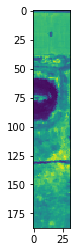

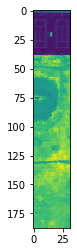

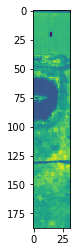

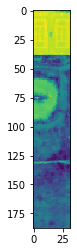

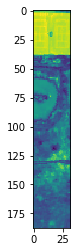

In [31]:
for smap in test1:
    plt.figure()
    plt.imshow(smap.reshape((neon_shp[0],neon_shp[1])))
    plt.show()

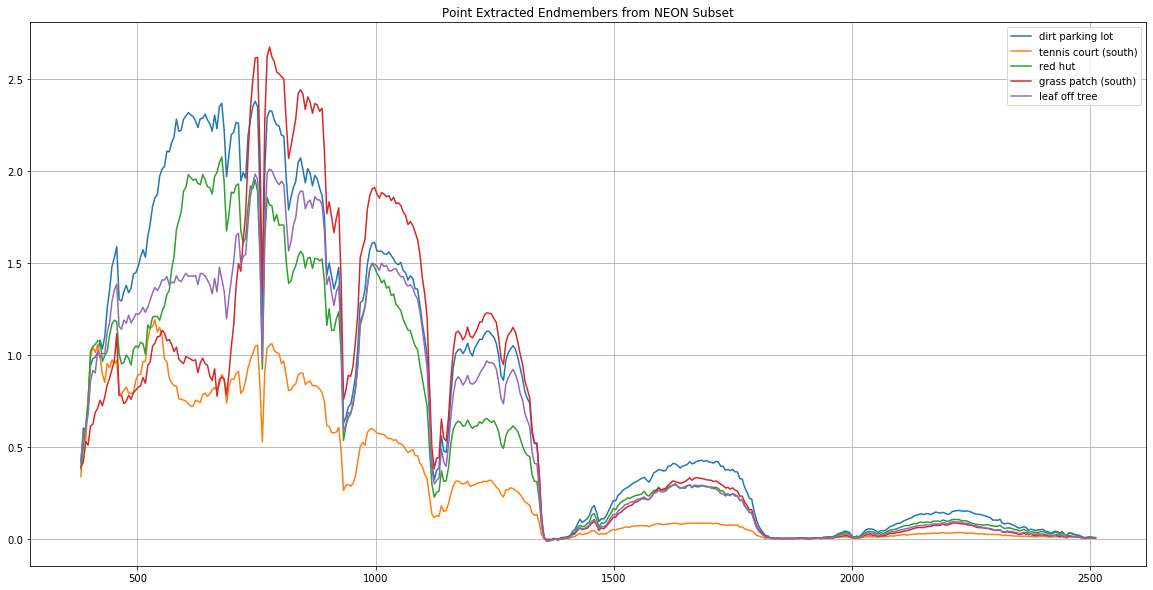

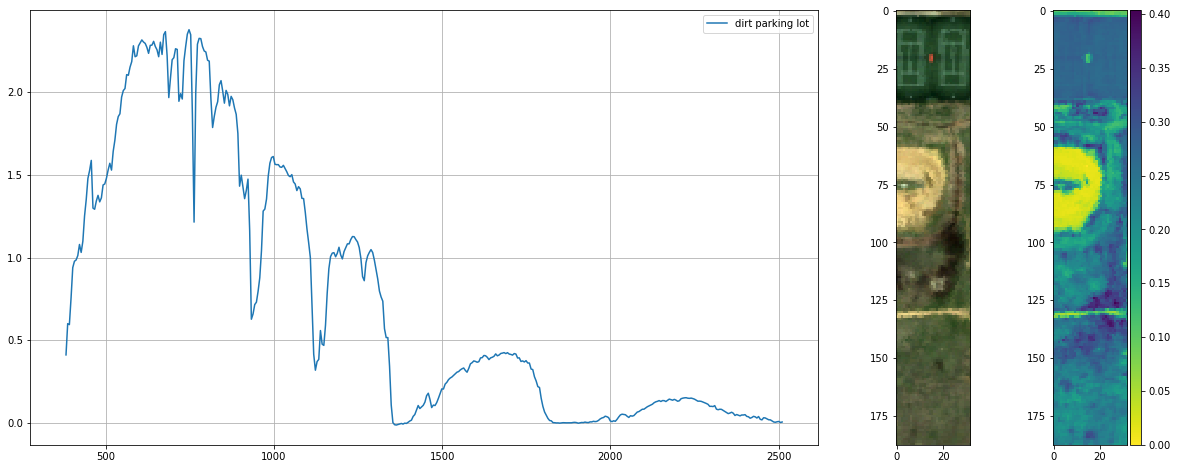

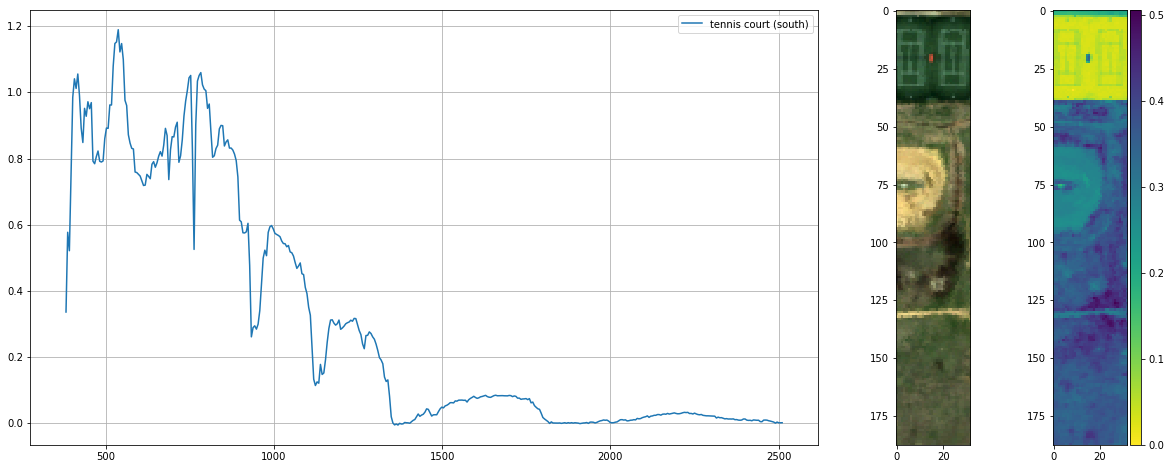

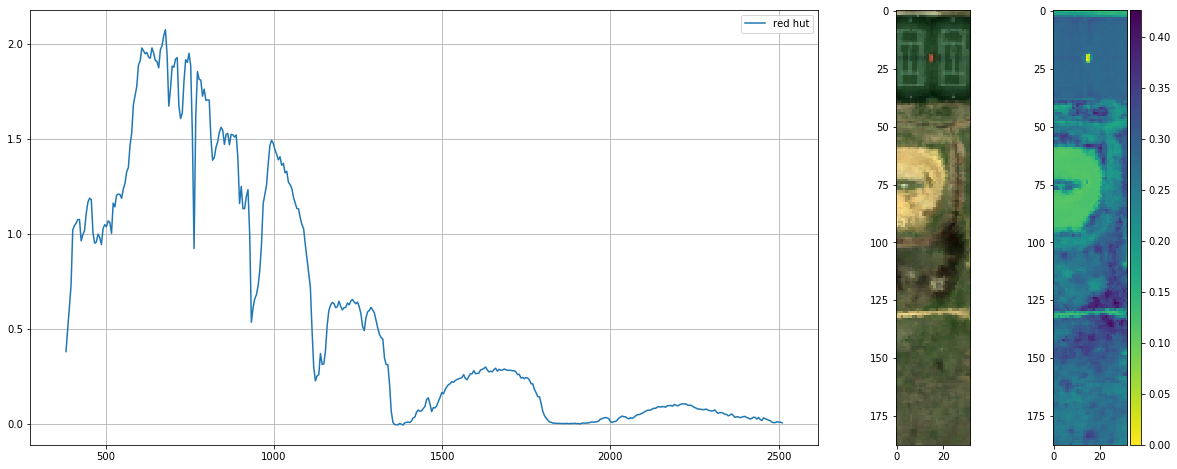

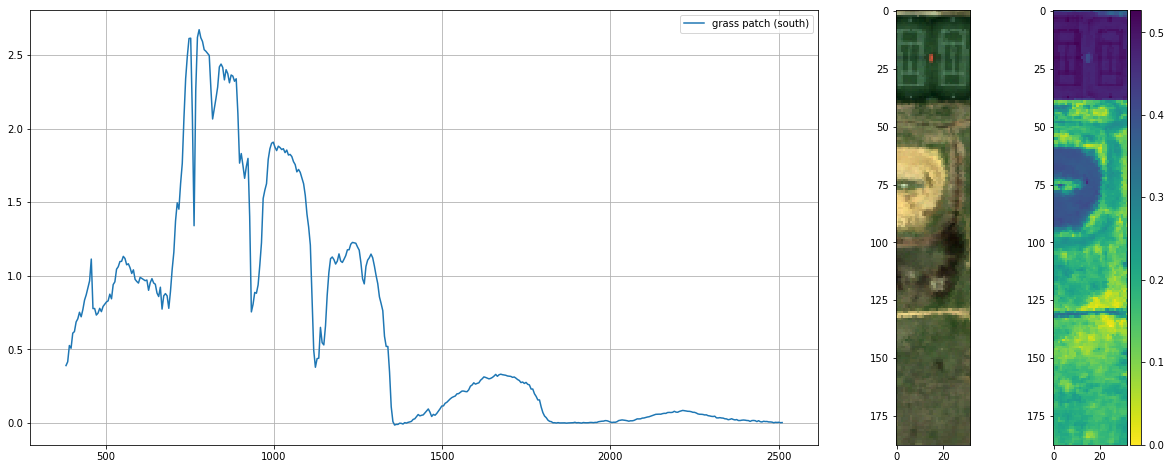

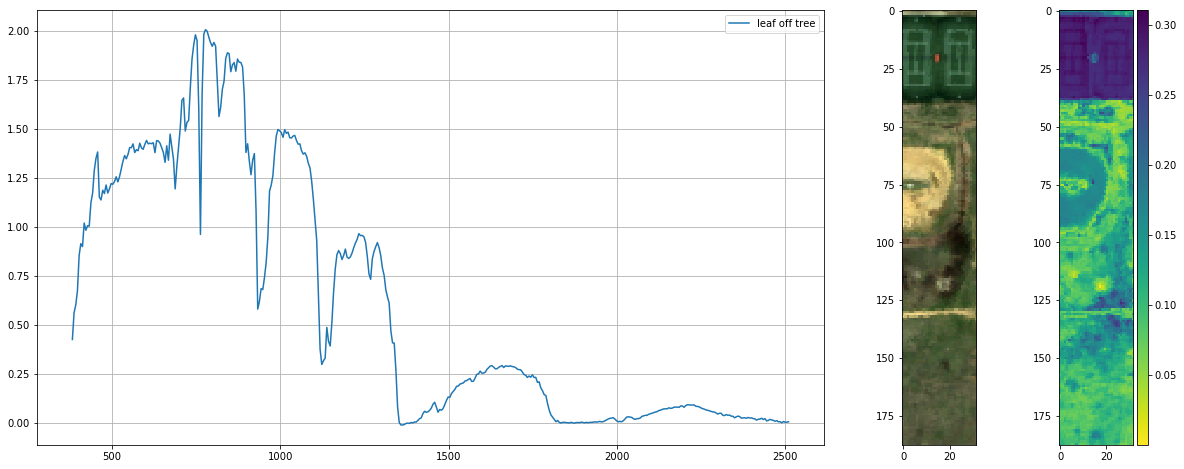

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [38]:
Ue = neon_pt_em
    
# plot them
plt.figure(figsize=(20,10))
for i, em in enumerate(Ue):
    plt.plot(neon_wav, em, label=gdf.comments[i])

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

# Plot the abundance maps
ab_maps = np.array([[SAM(sample, em) for sample in neon_reshp] for em in Ue]).reshape((neon_shp[0], neon_shp[1], 5))

for i,em in enumerate(Ue):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
    ax0.legend()
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

    ax2 = plt.subplot(gs[2])    
    smap = np.array([SAM(em, sample) for sample in neon_reshp]).reshape((neon_shp[0], neon_shp[1]))
    im2 = ax2.imshow(smap, cmap='viridis_r')


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="15%", pad=0.05)

    plt.colorbar(im2, cax=cax)
    plt.show()

print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')

# Try for Headwall

In [39]:
gdf_test = gdf_4326

def concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = xr.concat((vn,sw), dim=dim, join='left')
    
    return new_cube

def np_concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = np.concatenate((vn.values,sw.values))
    coords_dict = {'x': vn.coords['x'].values,
                   'y': vn.coords['y'].values,
                   'band': np.arange(1, new_cube.shape[0]+1)}
    attrs_dict = {'wavelength': np.concatenate((vn.coords['wavelength'].values, sw.coords['wavelength'].values))}
    
    return xr.DataArray(new_cube, dims=('band', 'y', 'x'), coords=coords_dict, attrs=attrs_dict)

def merge_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
#     if vn.shape != sw.shape:
#         warnings.warn('extracted shapes are not equal, shaving some off...')
        
#         min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
#         sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
#         vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
#     # next, check the x-y offsets. If needed, shift one or the other
#     x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
#     y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values - x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values - y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
    
    #interpolate into the higher resolution grid from IMERG
    vn = vn.interp(x=sw["x"], y=sw["y"])
    new_cube = xr.concat([vn, sw])
    
    return new_cube

hw_cubes = [np_concat_hw_arrays(pair) for pair in zip(xarr_VNIR_ls, xarr_SWIR_ls)]
x_hw = [x.coords['x'] for x in hw_cubes]
y_hw = [x.coords['y'] for x in hw_cubes]

hw_cubes[0].coords, hw_cubes[0].shape, hw_cubes[0].coords['band'].shape, hw_cubes[0].attrs['wavelength'].shape

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 559, 359) (270, 559, 359)


C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 593, 340) (270, 593, 340)


C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 617, 324) (270, 617, 324)


(Coordinates:
   * x        (x) float64 -105.2 -105.2 -105.2 -105.2 ... -105.2 -105.2 -105.2
   * y        (y) float64 39.98 39.98 39.98 39.98 ... 39.98 39.98 39.98 39.98
   * band     (band) int32 1 2 3 4 5 6 7 8 9 ... 486 487 488 489 490 491 492 493,
 (493, 559, 359),
 (493,),
 (493,))

In [40]:
res=[]
gdf_test2 = gdf_test.copy()
gdf_test2['geometry'] = gdf_test.to_crs(epsg=3857).buffer(0.5).to_crs(epsg=4326)

for hw_ind in range(3):
    
    print(f'on cube {hw_ind}')
    # create mask datasets for the VNIR and SWIR data separately
    ds_vnir = xr.Dataset(coords={'y':y_vnir_ls[hw_ind], 'x':x_vnir_ls[hw_ind]})
    shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

    temp_vnir = []
    for i, shape in enumerate(shapes):

        try:
            ds_vnir['aoi'] = rasterize([shape], ds_vnir.coords)
            ds_vnir['aoi'] = ds_vnir.aoi*0 + 1
            example_vnir = ds_vnir.aoi * xarr_VNIR_ls[hw_ind]

            val_y, val_x = np.where(ds_vnir.aoi==1)
            u_y = np.unique(val_y)
            u_x = np.unique(val_x)
            ex_vnir = example_vnir.sel(y=y_vnir_ls[hw_ind][val_y], x=x_vnir_ls[hw_ind][val_x])

            # cut off the VNIR if provided
            w_cutoff = 896
            if w_cutoff > 0:
                b_cutoff = np.where(ex_vnir.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
                ex_vnir = ex_vnir.sel(band=slice(0, b_cutoff))


            if ex_vnir.shape[0] == 0:
                temp_vnir.append(np.zeros((ex_vnir.shape[-1])))
            else:
                #temp_vnir.append(np.squeeze(ex_vnir)) # for points
                temp_vnir.append(np.nanmean(ex_vnir, axis=(0,1))) # for polygons

        except Exception as e:
            print(e)
            print(val_y, val_x, example_vnir.shape)
            print(f'shape {i} is not in VNIR file')
            print('***')

    #print(temp_vnir)
    vnir_stack = np.vstack(temp_vnir)

    # SWIR
    ds_swir = xr.Dataset(coords={'y':y_swir_ls[hw_ind], 'x':x_swir_ls[hw_ind]})
    shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

    temp_swir = []
    for shape in shapes:

        try:
            ds_swir['aoi'] = rasterize([shape], ds_swir.coords)
            ds_swir['aoi'] = ds_swir.aoi*0 + 1
            example_swir = ds_swir.aoi * xarr_SWIR_ls[hw_ind]

            val_y, val_x = np.where(ds_swir.aoi==1)
            u_y = np.unique(val_y)
            u_x = np.unique(val_x)
            ex_swir = example_swir.sel(y=y_swir_ls[hw_ind][val_y], x=x_swir_ls[hw_ind][val_x])

            if ex_swir.shape[0] == 0:
                temp_swir.append(np.zeros((ex_swir.shape[-1])))
            else:
                #temp_swir.append(np.squeeze(ex_swir)) # for points
                temp_swir.append(np.nanmean(ex_swir, axis=(0,1))) # for polygons
        except:
            print(e)
            print(val_y, val_x)
            print('shape is not in SWIR file')

    swir_stack = np.vstack(temp_swir)

    # concatenate the data
    full_ex = np.hstack((vnir_stack, swir_stack))


    # concatenate the wavelength vectors
    full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
    full_wav = np.unique(full_wav)
    
    res.append((full_ex, full_wav)) # for points
    

on cube 0
on cube 1
on cube 2


In [41]:
from collections import OrderedDict

# reduce endmembers since there are 3 'sets'
U_hw = []
for r in res:
    
    for i, em in enumerate(r[0]):
        if em.sum() > 0:
            U_hw.append((gdf_test.comments[i], em))
                    
U_hw_dict = OrderedDict(U_hw)

In [42]:
# resort the HW endmembers to match the original geodataframe
ix = [gdf_test2.where(gdf_test2.comments == k).dropna().index[0] for k in U_hw_dict.keys()]
ivals = [gdf_test2.loc[gdf_test2.comments == k].comments.iloc[0] for k in gdf_test2.comments]

for k in ivals: # a loop to force the order you want
    U_hw_dict.move_to_end(k)

ivals, ix, gdf_test2.comments.values, U_hw_dict.keys()

(['dirt parking lot',
  'tennis court (south)',
  'red hut',
  'grass patch (south)',
  'leaf off tree'],
 [1, 2, 0, 4, 3],
 array(['dirt parking lot', 'tennis court (south)', 'red hut',
        'grass patch (south)', 'leaf off tree'], dtype=object),
 odict_keys(['dirt parking lot', 'tennis court (south)', 'red hut', 'grass patch (south)', 'leaf off tree']))

In [43]:
U_hw_arr = []
for h in U_hw_dict:
    U_hw_arr.append(U_hw_dict[h])
    
U_hw_arr = np.array(U_hw_arr)

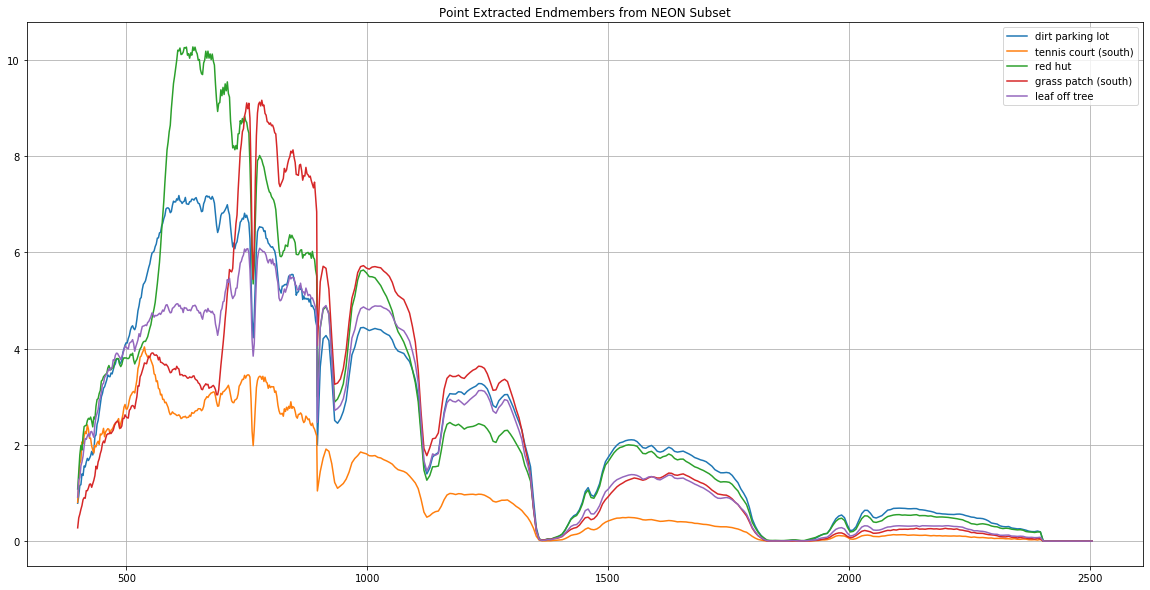

C:\software\anaconda3\envs\geo_py\lib\site-packages\pysptools\distance\dist.py:49: RuntimeWarning: invalid value encountered in double_scalars
  angle = math.acos(sum_s1_s2 / (s1_norm * s2_norm))


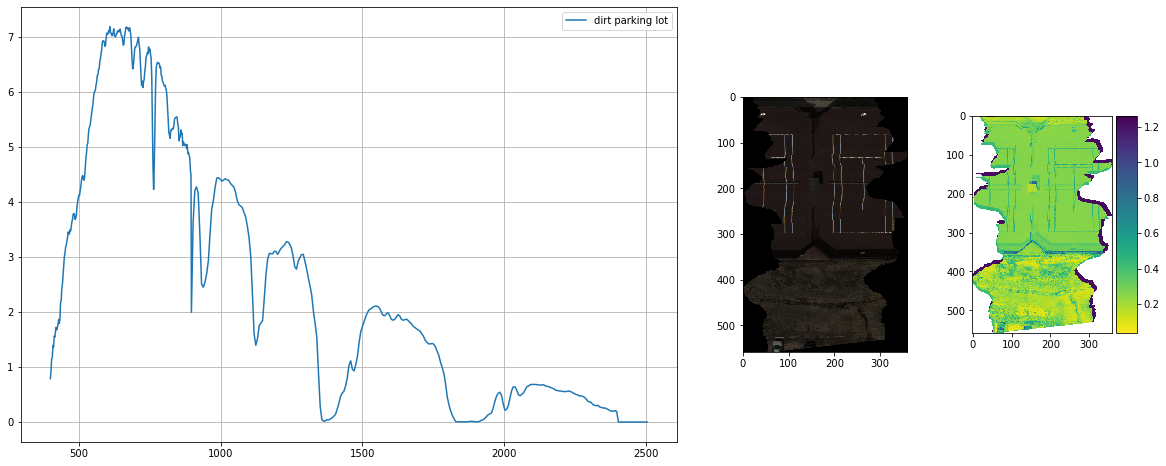

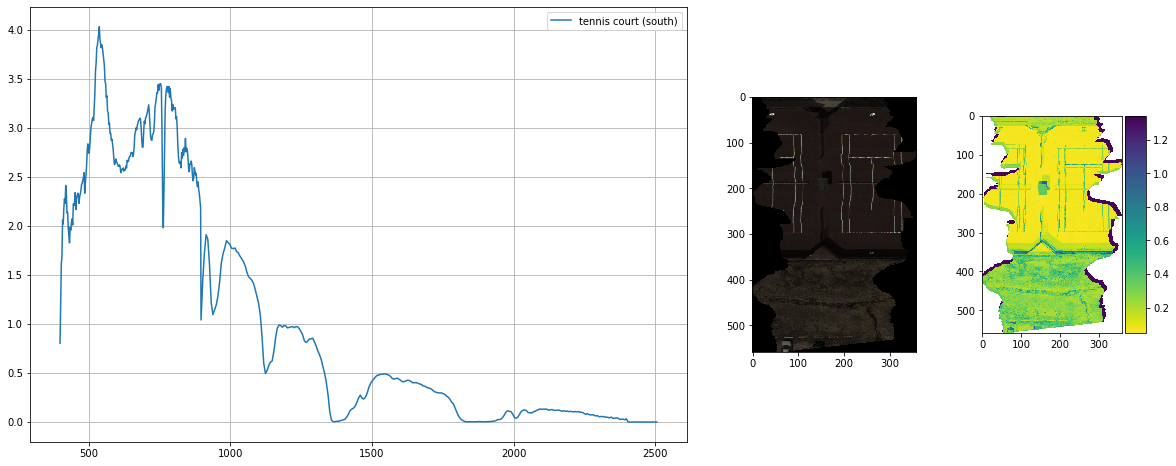

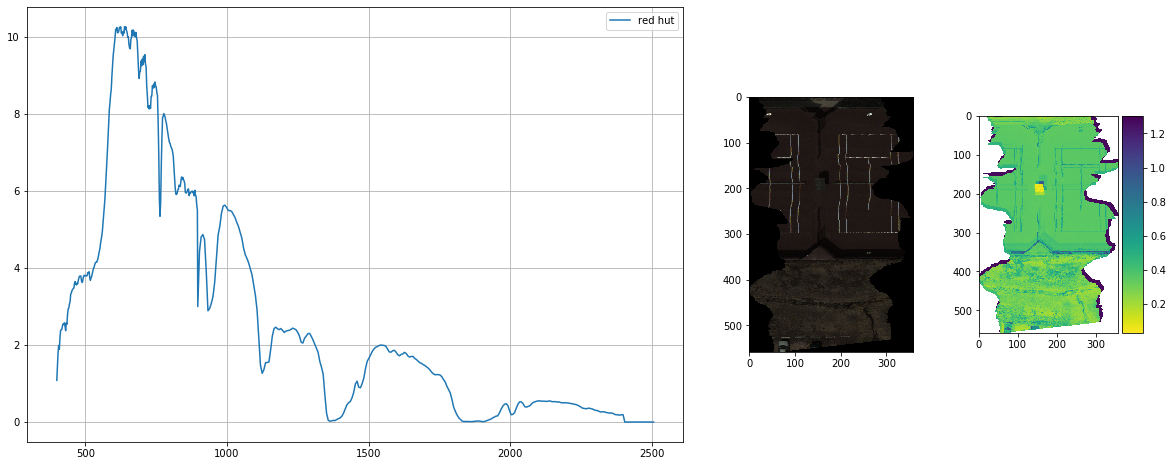

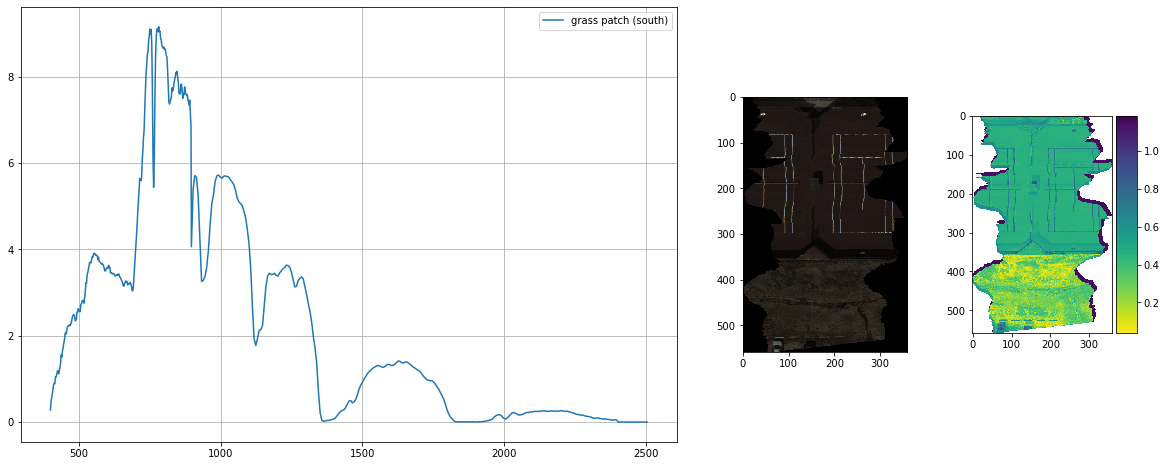

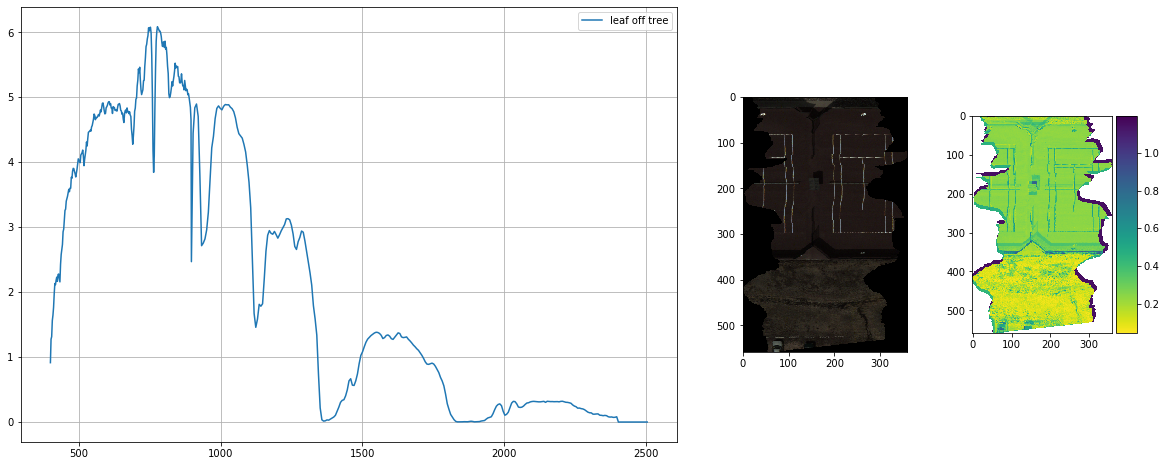

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


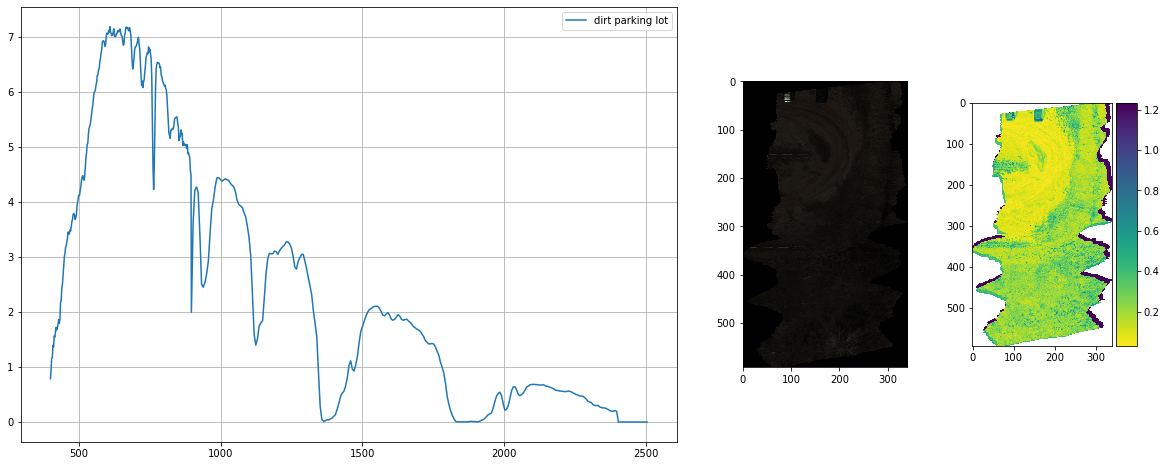

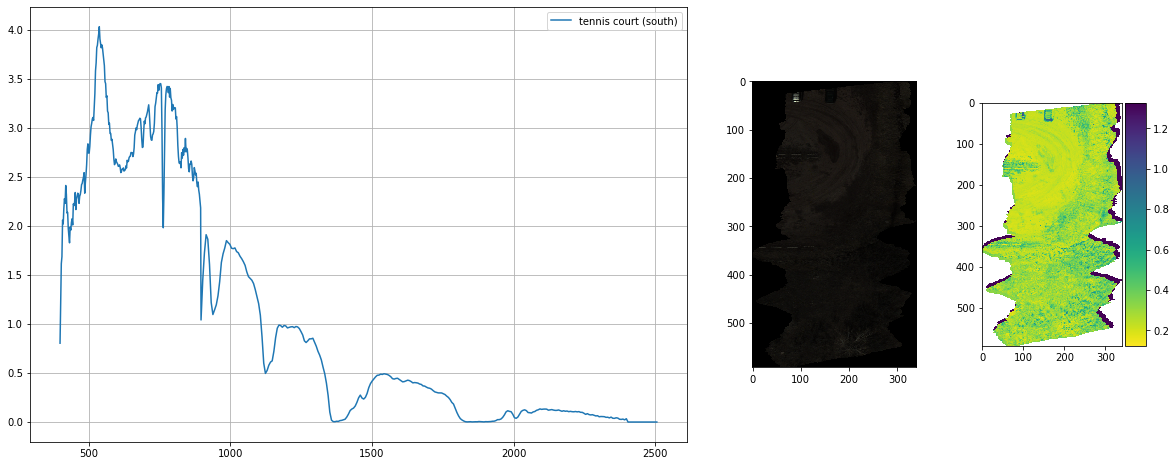

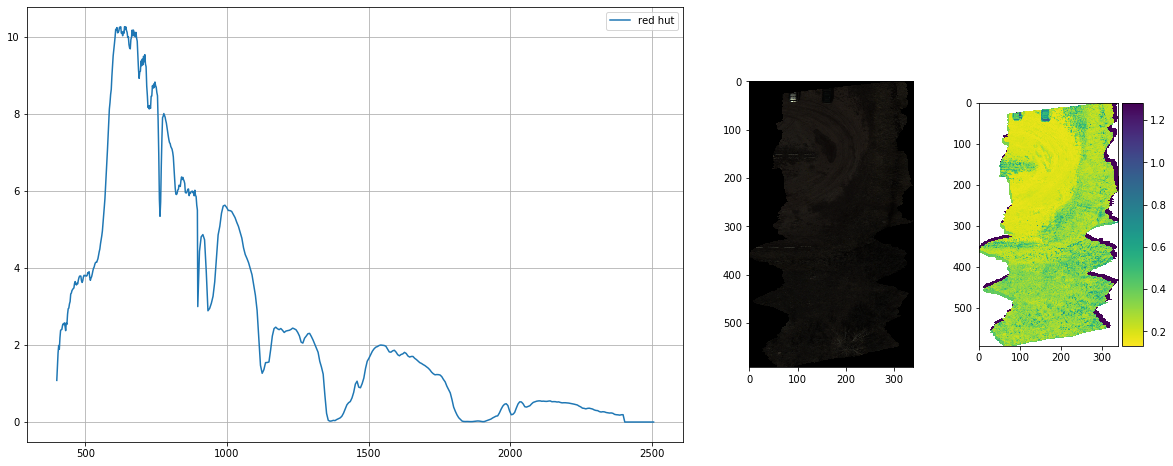

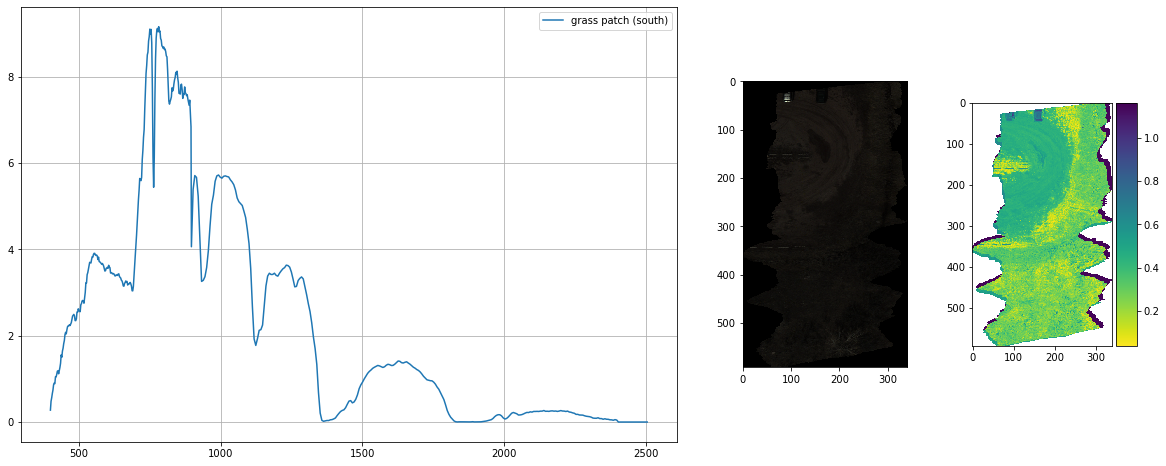

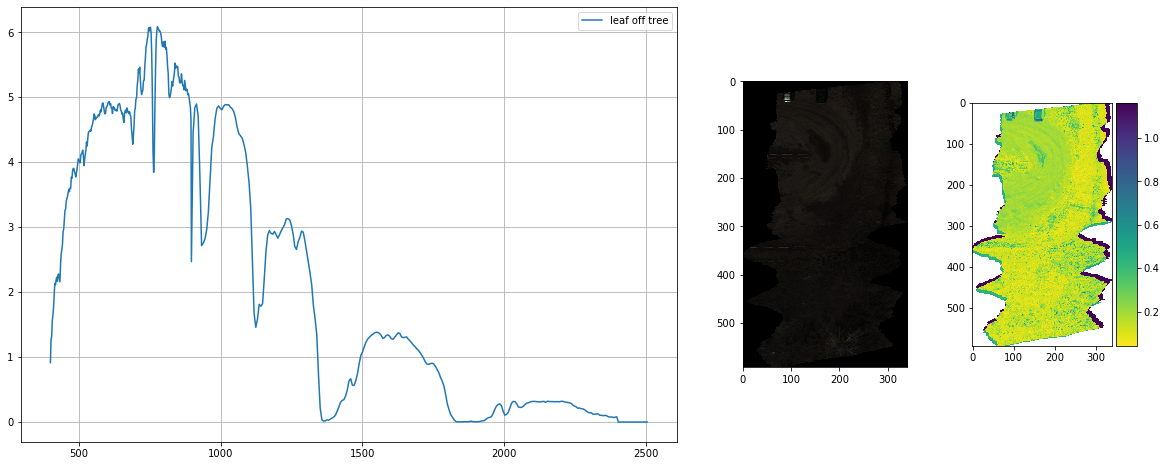

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


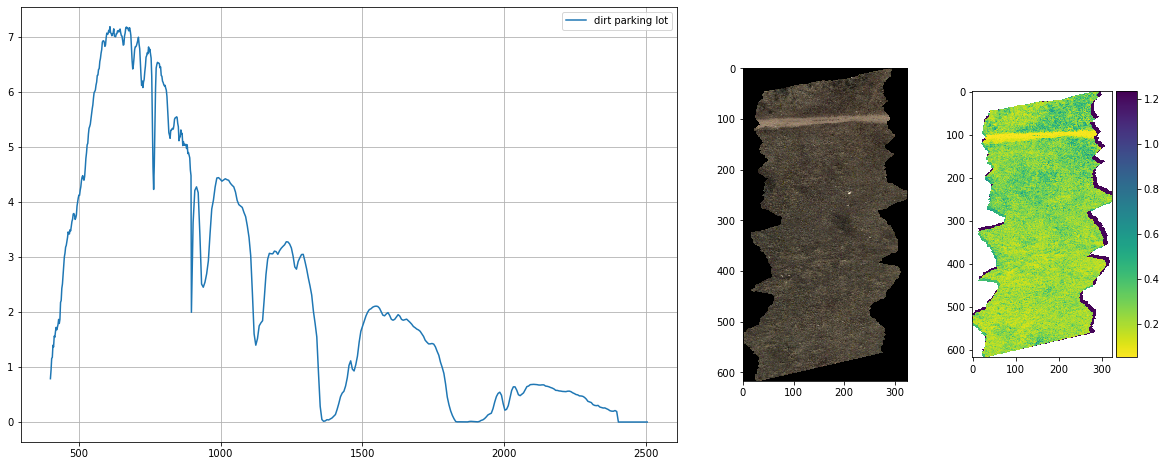

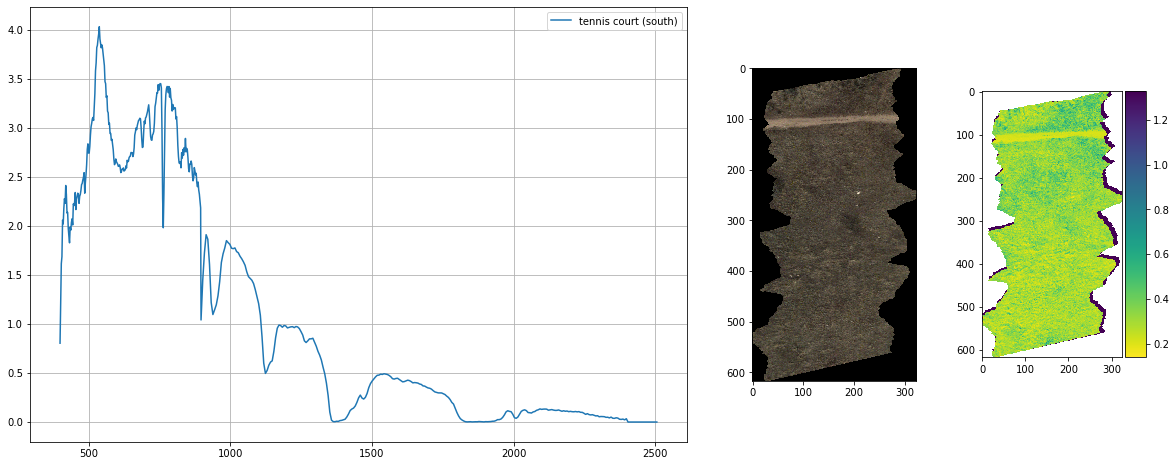

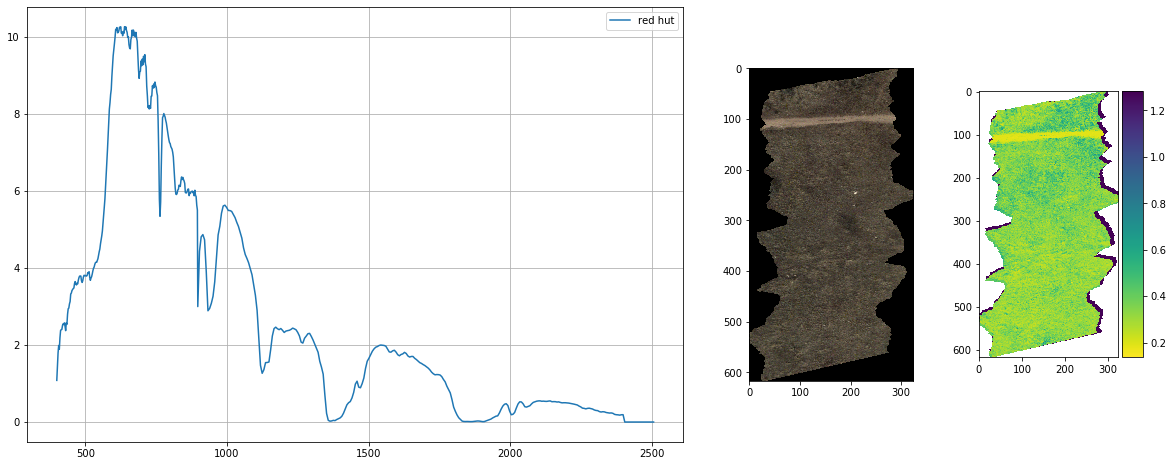

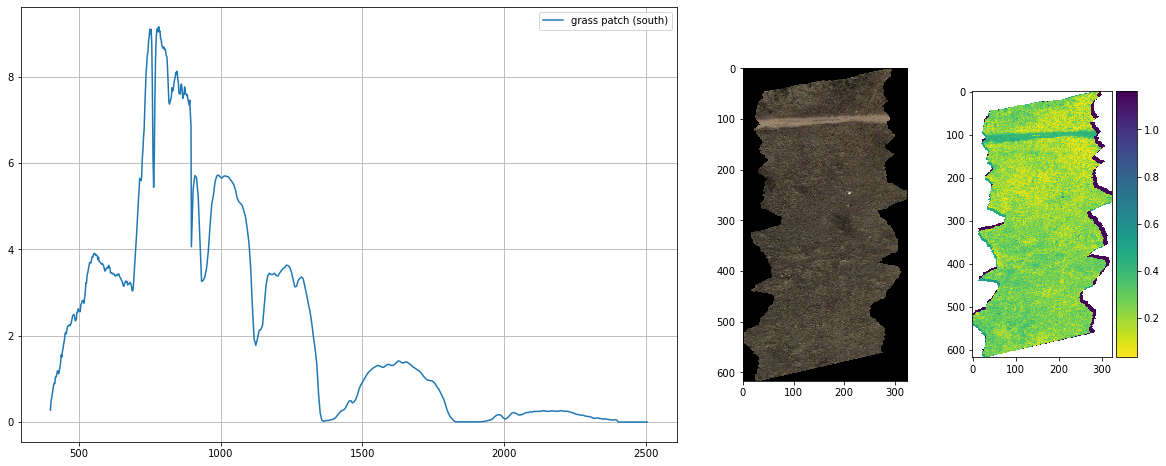

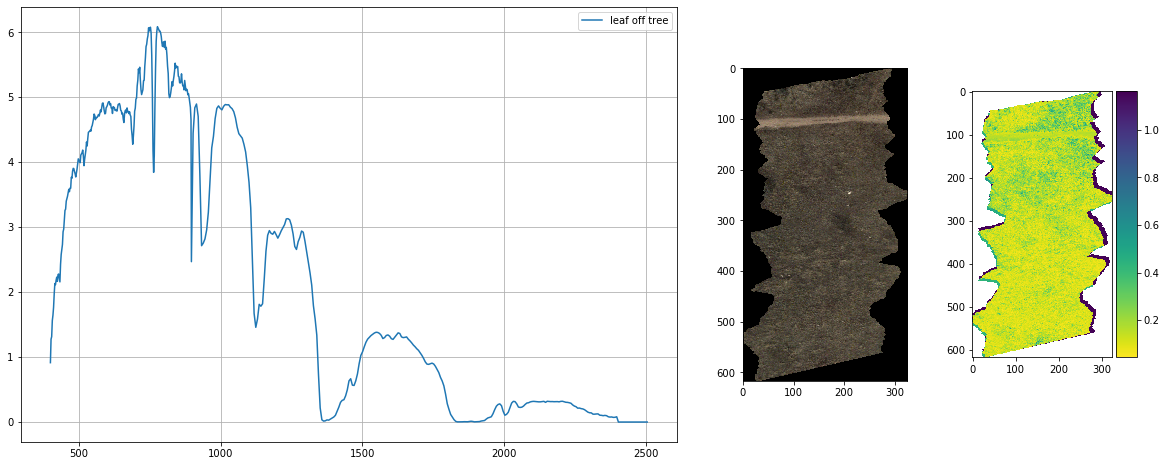

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [53]:
# plot them
hw_wav = res[0][1]
plt.figure(figsize=(20,10))
for h in U_hw_dict:
    plt.plot(hw_wav, U_hw_dict[h], label=h)

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

for j in range(3):
    # Plot the abundance maps
    
    # test_plot = hw_cubes[0].transpose('y', 'x', 'band').values[200:-250,100:200,:]
    # test_plot = np.rollaxis(hw_cubes[0].values[:,200:-250,190:220], 0, 3)
    #test_plot = np.rollaxis(hw_cubes[j].values[:,50:-50,100:-100], 0, 3)
    # test_plot =  np.rollaxis(hw_cubes[0].values, 0, 3)
    
    test_plot = hw_cubes[j].transpose('y', 'x', 'band').values
    hw_shp = test_plot.shape
    test_plot1 = test_plot.reshape((hw_shp[0]*hw_shp[1], hw_shp[2]))
    test_plot1[~np.isfinite(test_plot1)] = 0

    for i,h in enumerate(U_hw_dict):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(hw_wav, U_hw_dict[h], label=h)
        ax0.legend()
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(test_plot[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        smap = np.array([SAM(sample, U_hw_dict[h]) for sample in test_plot1]).reshape((hw_shp[0], hw_shp[1]))
        im2 = ax2.imshow(smap, cmap='viridis_r')


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()

    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')

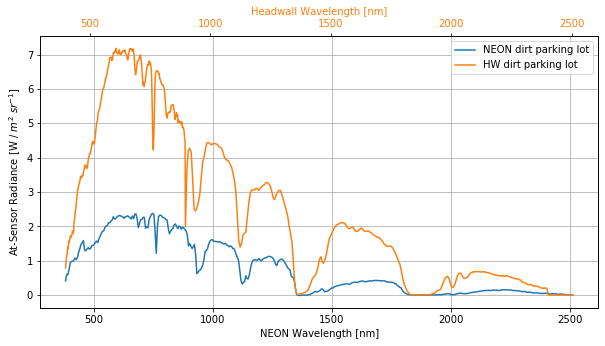

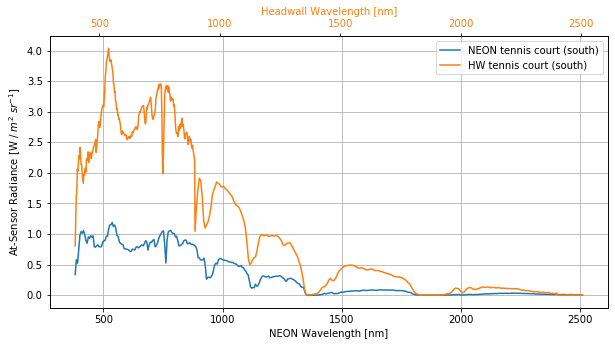

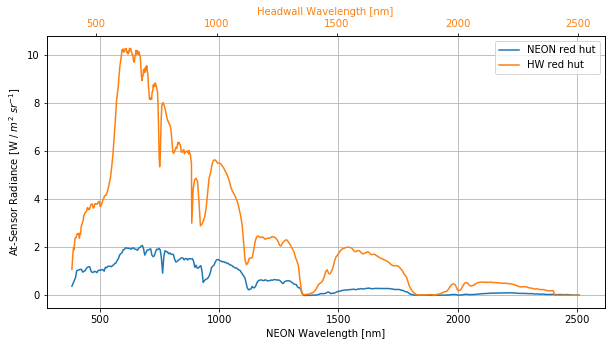

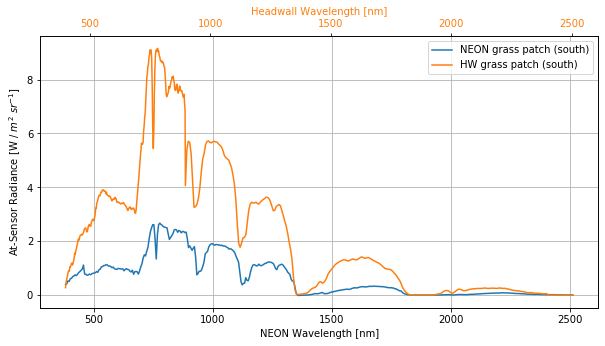

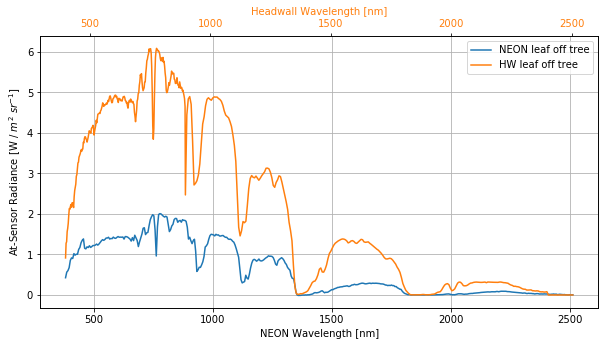

In [54]:
# plot the endmembers against each other
i=0
for em_n, em_h,k in zip(Ue, U_hw_dict.values(), U_hw_dict.keys()):
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    l1 = ax1.plot(neon_wav, em_n, label=f'NEON {k}')
    ax1.set_xlabel('NEON Wavelength [nm]')
    ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

    color = 'tab:orange'
    ax2.set_xlabel('Headwall Wavelength [nm]', color=color)  # we already handled the x-label with ax1
    l2 = ax2.plot(full_wav, em_h, color=color, label=f'HW {k}')
    ax2.tick_params(axis='x', labelcolor=color)
    
    #plt.plot(em_h, label=f'hw {k}')
    
    #ax1.legend()
    #ax2.legend(loc=3)
    
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    
    ax1.grid(True)
    #plt.xlabel('Wavelength [nm]')
    ax1.set_ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
    #plt.grid(True)
    plt.show()
    
    i+=1

# next thing... Subset NEON cube by each headwall cube and calculate spectral angle.

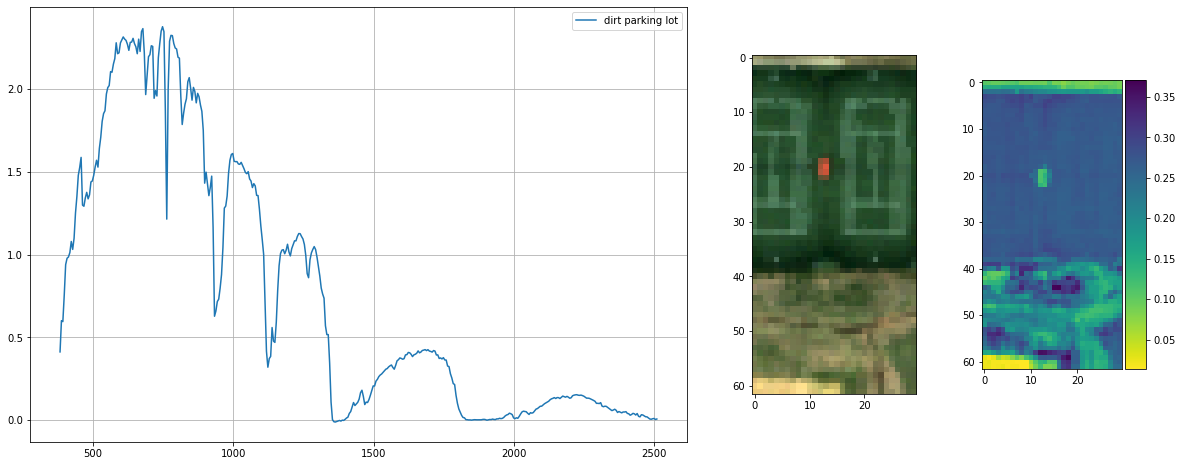

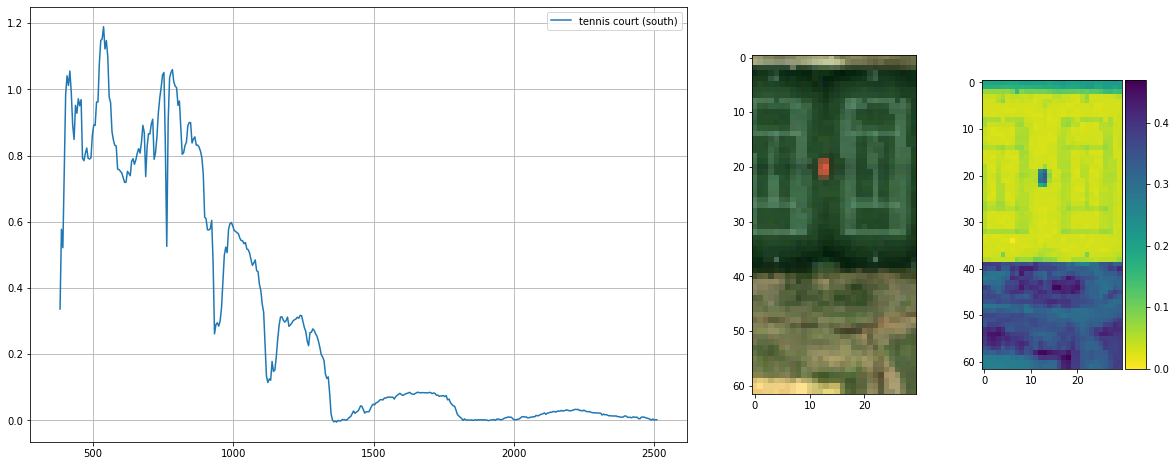

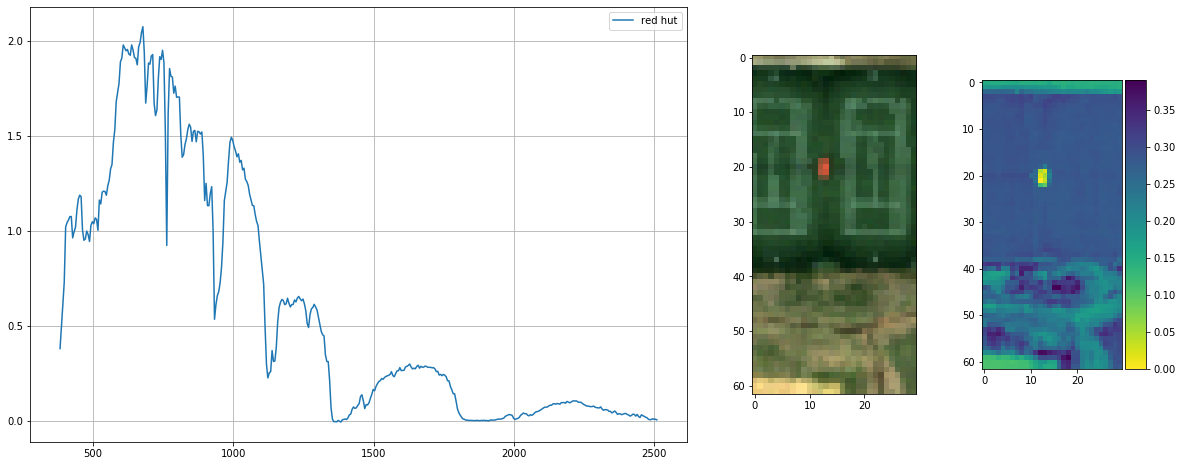

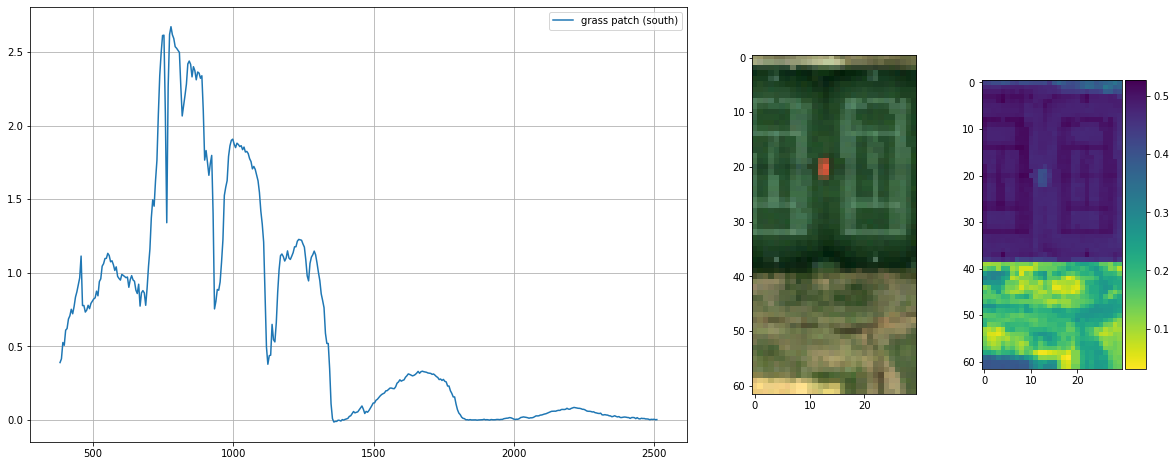

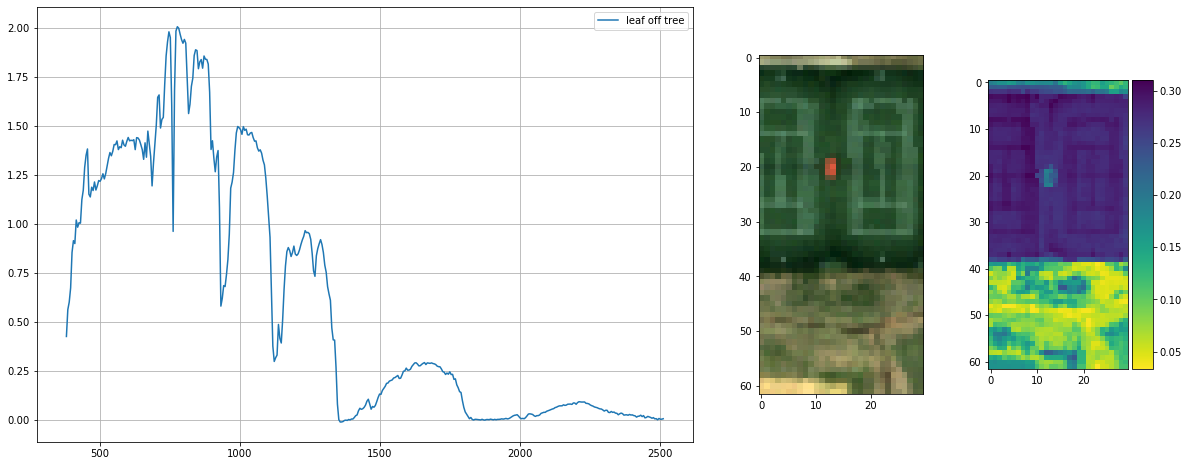

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


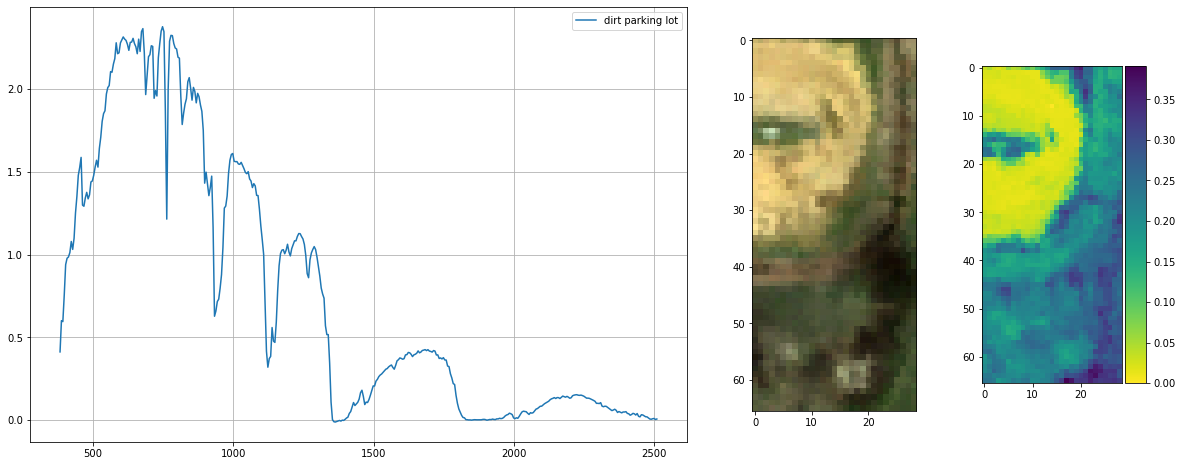

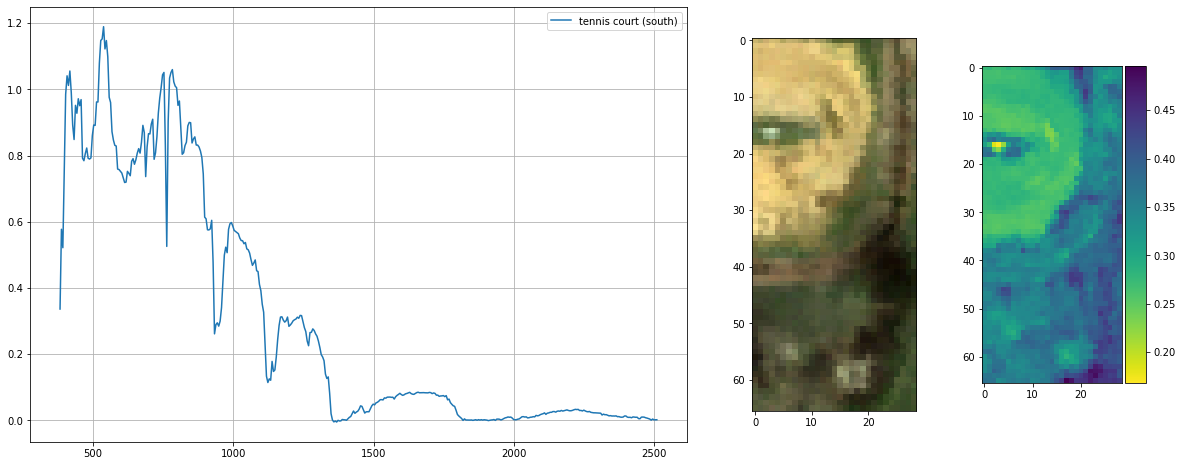

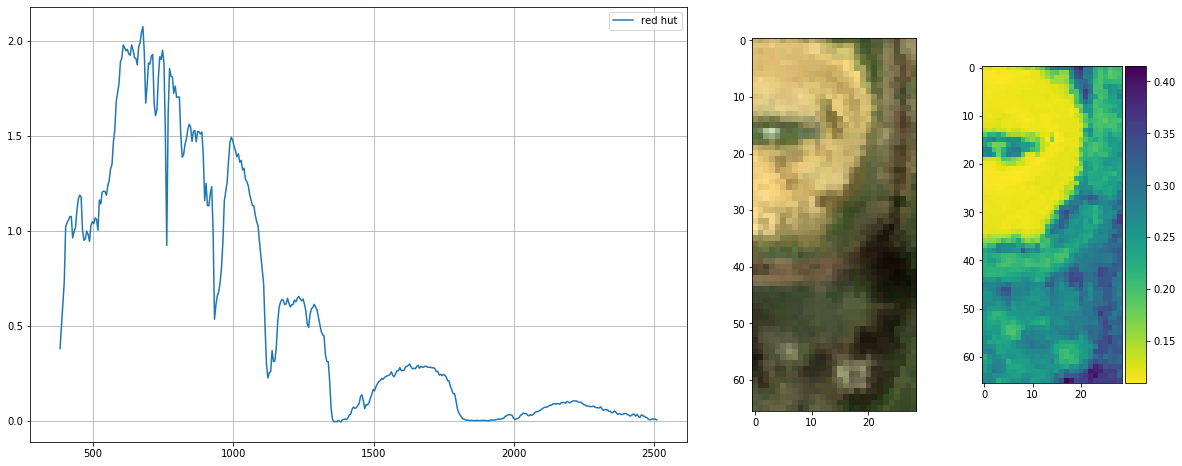

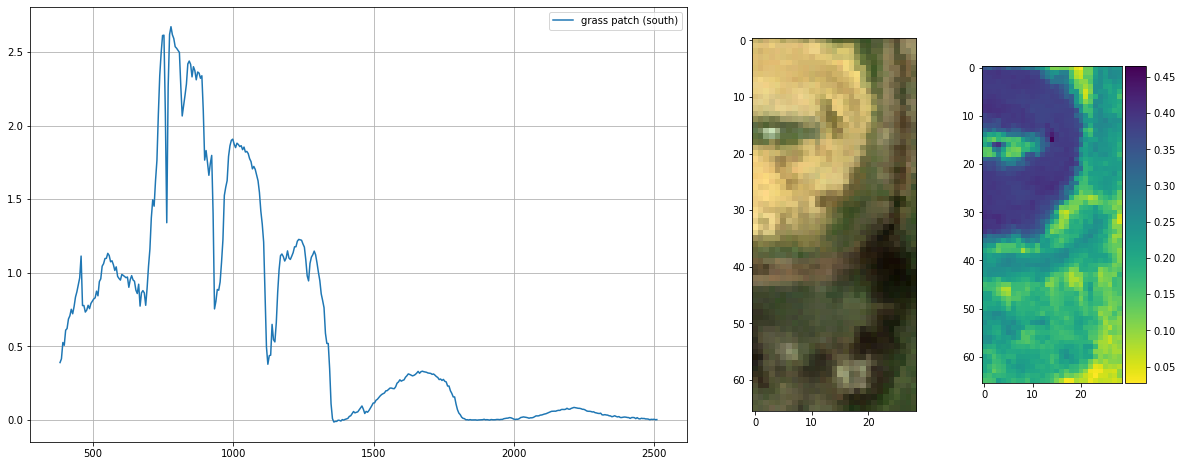

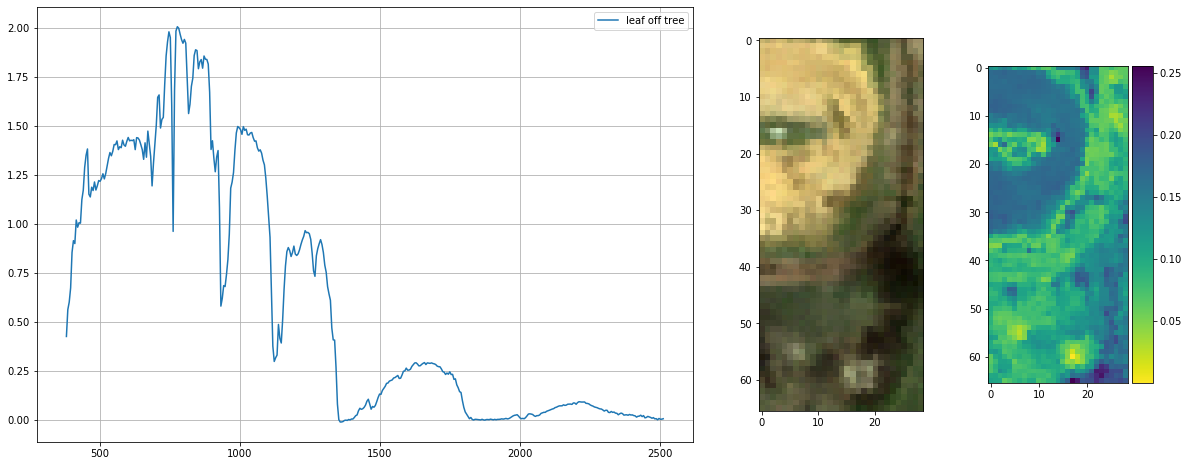

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


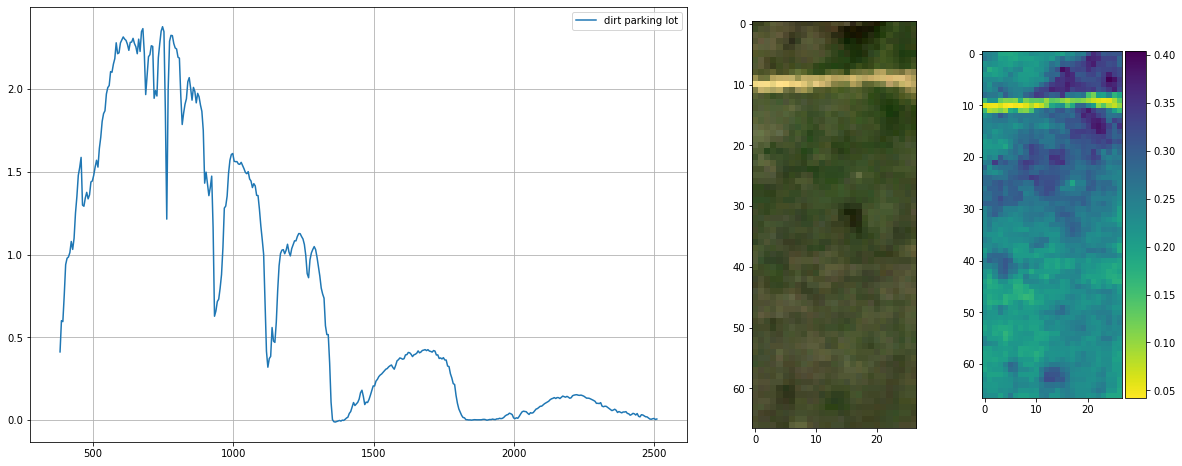

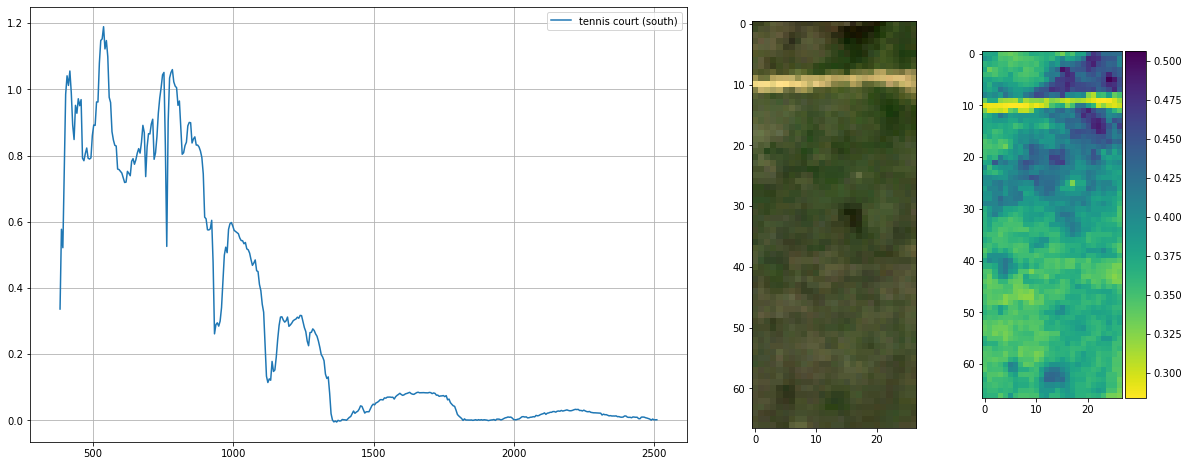

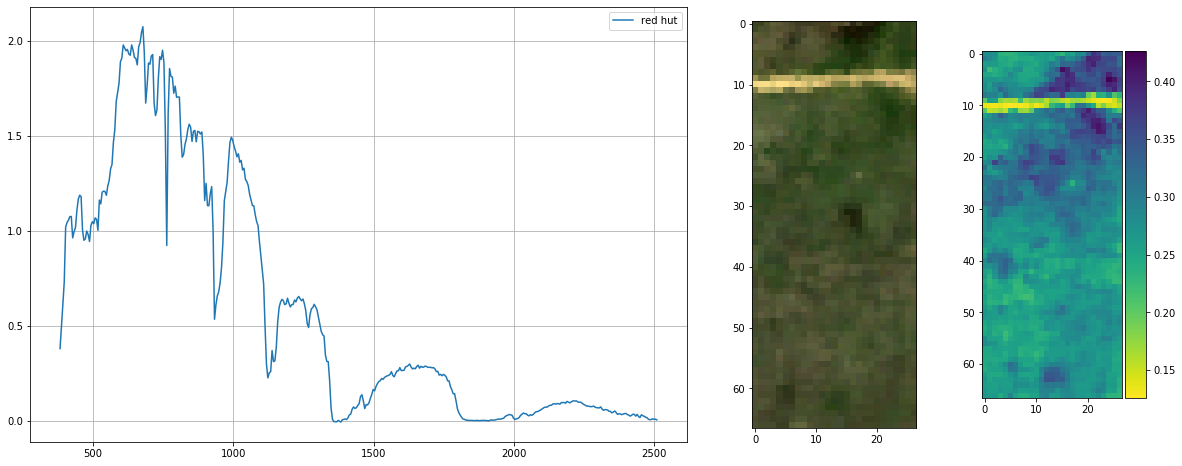

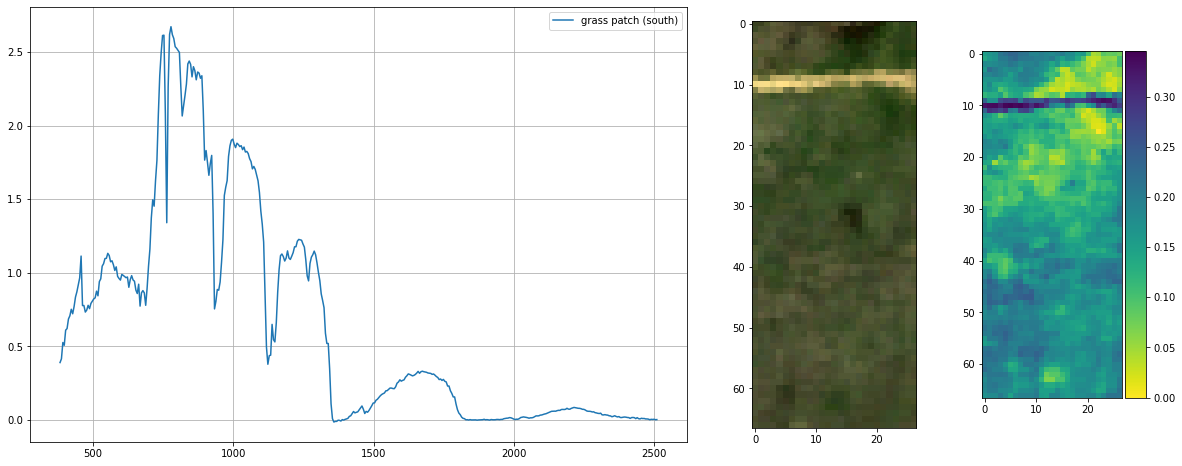

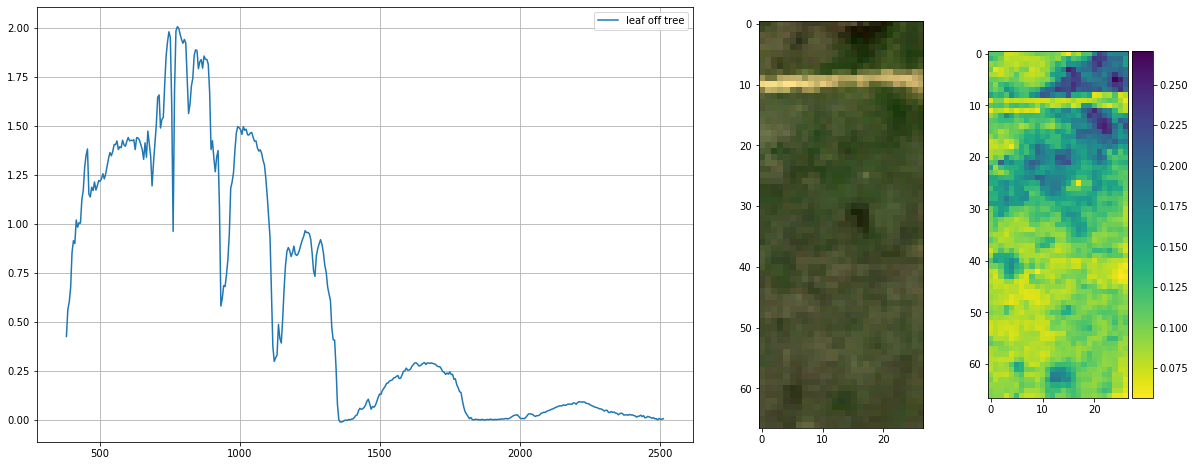

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [57]:
# subset the NEON data with the full extent of headwall data cubes
j=0
for x,y in zip(x_vnir_ls, y_vnir_ls):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    bbox = box(xmin, ymin, xmax, ymax)
    chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
    neon_wav, full_neon = neon_arrs
    
    # some weird nodata stripe
    if j==2:
        neon_sub_cube=neon_sub_cube[1:,1:,:]
        
    # Plot the SAM maps

    for i,em in enumerate(Ue):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
        ax0.legend()
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        neon_shp = neon_sub_cube.shape
        neon_reshp = neon_sub_cube.values.reshape((neon_shp[0]*neon_shp[1], neon_shp[2]))
        smap = np.array([SAM(sample, em) for sample in neon_reshp]).reshape((neon_shp[0], neon_shp[1]))
        im2 = ax2.imshow(smap, cmap='viridis_r')


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()

    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    
    j+=1

# scribbles


In [ ]:
# need to update helper functions to do this processing if geometries are POINTS
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(ex_neon)
    
# ex_neon.shape, ds_neon['aoi'].shape, example_neon.shape

In [ ]:
from shapely.geometry.point import Point
type(gdf.geometry[0]) is Point

In [ ]:
import pandas as pd


In [ ]:
gps_fi = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM1.txt"
gps_df = pd.read_csv(gps_fi, delimiter='\t')
gps_df.head()

In [ ]:
gps_df['Gps_UTC_Date&Time'].dtype

In [ ]:
# gps_df.plot(y='Gps_UTC_Date&Time')
gps_df.plot(y='Alt', x='Timestamp')

In [ ]:
gps_fi2 = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM2.txt"
gps_df2 = pd.read_csv(gps_fi2, delimiter='\t')
gps_df2.plot(y='Alt', x='Timestamp')

In [ ]:
p1 = gps_df.plot(y='Alt', x='Timestamp', label='flight1')
gps_df2.plot(y='Alt', x='Timestamp', ax=p1, label='flight2')
plt.show()

In [ ]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)